### Elementy sztucznej inteligencji
# Projekt: Binarne Drzewa Decyzyjne
autorzy:
1. Arkadiusz Florek
2. Maciej Komosa
3. Albert Pieniądz
4. Jakub Zięba

Importowanie bibliotek

In [110]:
import numpy as np, pandas as pd
from math import log2

Obliczanie entropii

In [259]:
def _entropia(dane):
    '''
    słownik:
    klucz - konkluzja
    wartość - liczba wystąpień konkluzji
    '''
    slownik = {}
    for _ in dane:
        atr = _[-1]
        if atr not in slownik:
            slownik[atr] = 0
        slownik[atr] += 1

    '''
    entropia:
    suma p * log2(p)
    '''
    entropia = 0.0
    for _ in slownik.values():
        p = _ / len(dane)
        entropia -= p * log2(p)

    return entropia

Obliczanie zysku informacji

In [271]:
def _zysk_informacji(dane, przeslanka):
        '''
        slownik:
        klucz - wartość przesłanki
        wartość - lista wierszy spełniających przesłankę
        '''
        slownik = {}
        for _ in dane:
            wartosc = _[przeslanka]
            if wartosc not in slownik:
                slownik[wartosc] = []
            slownik[wartosc].append(_)
    
        '''
        obliczanie entropii przed i po podzieleniu
        '''
        ilosc_wierszy = len(dane)
        entropie = []
        for wartosci_przeslanki in slownik.values():
            ilosc_wartosci_przeslanki = len(wartosci_przeslanki)
            entropia_przeslanki = _entropia(wartosci_przeslanki)
            entropie.append((ilosc_wartosci_przeslanki / ilosc_wierszy) * entropia_przeslanki)
        entropia_przeslanki = sum(entropie)
    
        '''
        zysk informacji
        '''
        zysk = _entropia(dane) - entropia_przeslanki
    
        return zysk

Obliczanie przeslanki o najwiekszym zysku

In [310]:
def _przeslanka_o_najwiekszym_zysku(dane, nazwy_przeslanek, przeslanki_indeksy):

        '''
        oblicza dla wszystkich przesłanek zyski i wybiera tę najlepszą
        '''

        entropie_przeslanek = [_zysk_informacji(dane, przeslanka) for przeslanka in przeslanki_indeksy]
        indeks_przeslanka_o_najwiekszym_zysku = przeslanki_indeksy[entropie_przeslanek.index(max(entropie_przeslanek))]

        if max(entropie_przeslanek) == 0:
            return None, None
        
        return nazwy_przeslanek[indeks_przeslanka_o_najwiekszym_zysku], indeks_przeslanka_o_najwiekszym_zysku

Algorytm id3

In [317]:
def _id3(dane, atrybuty):
        '''
        inicjalizuje drzewo, czyli listę zbudowaną z kolejnych węzłów
        i połączeń pomiędzy nimi
        '''
        drzewo = [] 
        '''
        slownik:
        klucz - konkluzja
        wartość - liczba wierszy dla danej konkluzji
        '''
        (klucze, czestosci) = np.unique(dane[:, -1], return_counts=True)
        slownik = dict(zip(klucze, czestosci))
        '''
        dla każdej konkluzji sprawdza, czy jest jedyną konkluzją w zbiorze.
        jeśli tak, zwraca konkluzję jako węzeł liściowy
        '''
        for wartosc in slownik:
            if slownik[wartosc] == len(dane):
                drzewo.append(wartosc)
                return drzewo
        '''
        jeśli nie ma atrybutów, zwraca konkluzję o największej liczbie wystąpień
        '''
        if len(atrybuty) == 0:
                drzewo.append(max(slownik, key=slownik.get))
                return drzewo
        '''
        oblicza przeslankę o największym zysku, dodaje ją do drzewa i usuwa z listy atrybutów
        '''
        przeslanka, indeks_przeslanka = _przeslanka_o_najwiekszym_zysku(dane, atrybuty, range(len(atrybuty)))
        if przeslanka is None:
                return None
        drzewo.append(przeslanka)
        atrybuty = np.delete(atrybuty, indeks_przeslanka)
        for wartosc in np.unique(dane[:, indeks_przeslanka]):
                podzbior = dane[dane[:, indeks_przeslanka] == wartosc]
                podzbior = np.delete(podzbior, indeks_przeslanka, axis=1)
                przeslanka, indeks_przeslanka = _przeslanka_o_najwiekszym_zysku(podzbior, atrybuty, range(len(atrybuty)))
                if przeslanka is None:
                        break
                drzewo.append([wartosc, _id3(podzbior, atrybuty)])

        return drzewo

Graf

In [319]:
from graphviz import Digraph

def _rysuj_drzewo(drzewo, graf=None, i=0, s = ""):
        if graf is None:
                graf = Digraph()
        if i == 0:
                graf.node(s + str(i), drzewo[0])
        
        #rozgalezienia
        if isinstance(drzewo, str):
                graf.node(s + str(i), drzewo)
                graf.edge(s + str(i-1), s + str(i))
                return graf
        #galezie
        for j in range(1, len(drzewo)):
                
                if drzewo[j][1] == None:
                        break
                graf.node(s + str(i) + str(j), drzewo[j][1][0])
                if drzewo[j][0] == "0":
                        decyzja = "nie"
                else:
                        decyzja = "tak"
                graf.edge(s + str(i), s + str(i) + str(j), label=decyzja)
                _rysuj_drzewo(drzewo[j][1], graf, j, s + str(i))
                
        return graf


Zadanie

['zamieszkanie: miasto', ['0', ['typ: tr. wytrzymałościowy', ['0', ['poziom: początkujący', ['0', ['towarzystwo: indywidualnie', ['0', ['czestotliwosc/tydz: <2', ['0', ['poziom: amator']], ['1', ['pocziom: zaawansowany']]]], ['1', ['czestotliwosc/tydz: >5', ['0', ['poziom: amator']], ['1', ['czestotliwosc/tydz: 3-5']]]]]]]], ['1', ['towarzystwo: w grupie', ['0', ['czestotliwosc/tydz: >5', ['0', ['pocziom: zaawansowany']], ['1', ['czestotliwosc/tydz: 3-5']]]], ['1', ['towarzystwo: w parze', ['0', ['pocziom: zaawansowany']], ['1', ['towarzystwo: indywidualnie']]]]]]]]]


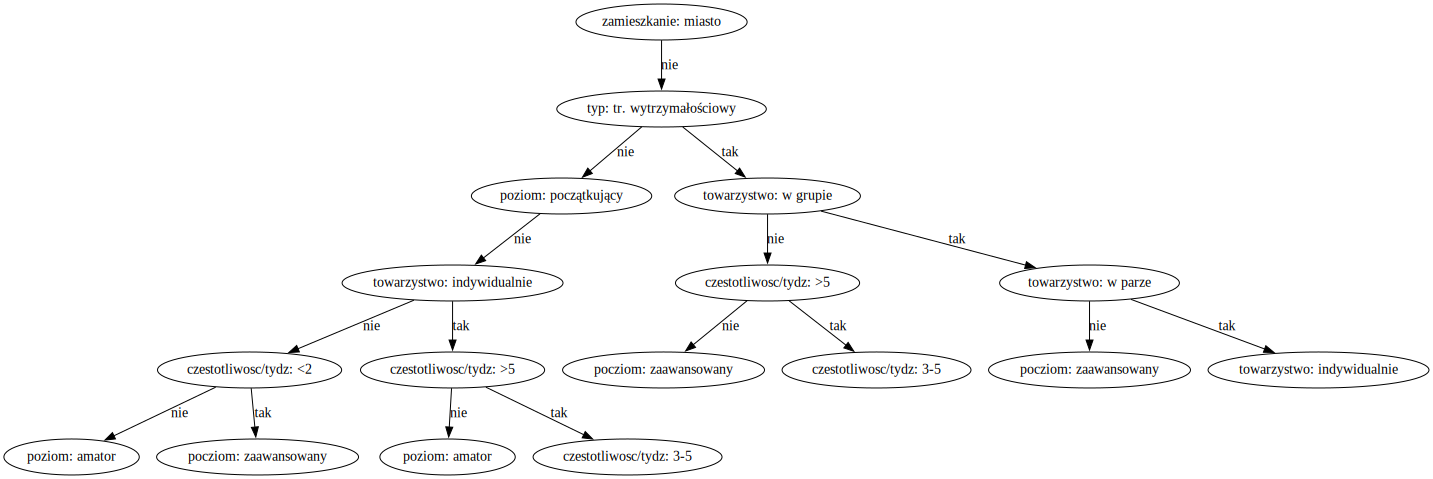

In [320]:
dane = pd.read_csv("sport_binarnie.csv", header=None).to_numpy()
drzewo = _id3(dane[1:, :], dane[0, :-1])
print(drzewo)
_rysuj_drzewo(drzewo)